# 1. Get Data

In [1]:
import kagglehub

path = kagglehub.dataset_download("ashkhagan/figshare-brain-tumor-dataset")

print("Path to dataset files:", path)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 839M/839M [01:19<00:00, 11.1MB/s] 

Extracting files...


Path to dataset files: /Users/horiaionescu/.cache/kagglehub/datasets/ashkhagan/figshare-brain-tumor-dataset/versions/1


# 2. Export from matlab and visualize

Dataset Shapes:
X_tumor: (3064, 256, 256, 1)
Y_tumor_mask: (3064, 256, 256, 1)
Tumor Labels: (3064,)
Unique Labels: [1 2 3]


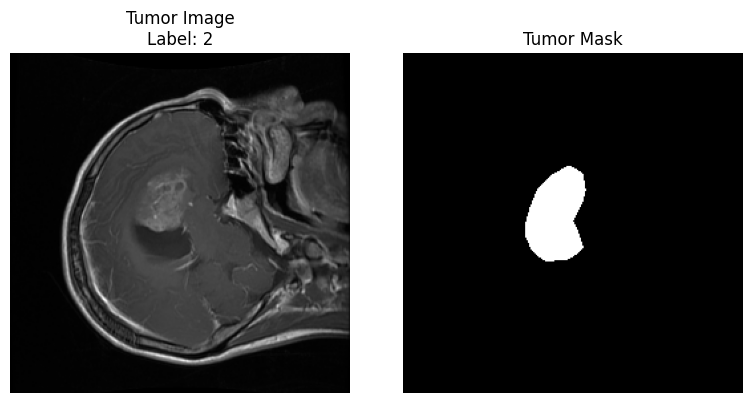

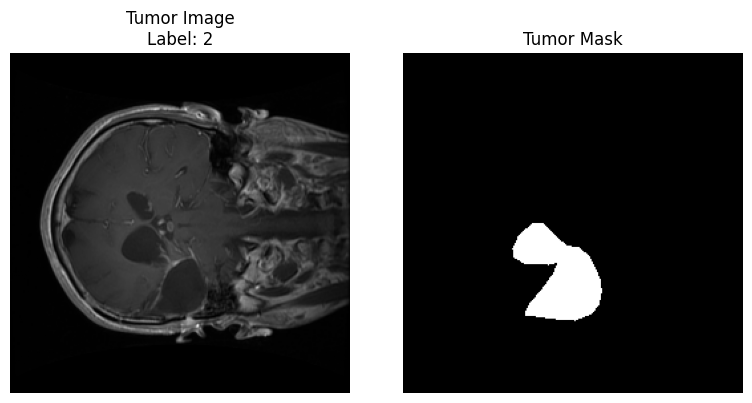

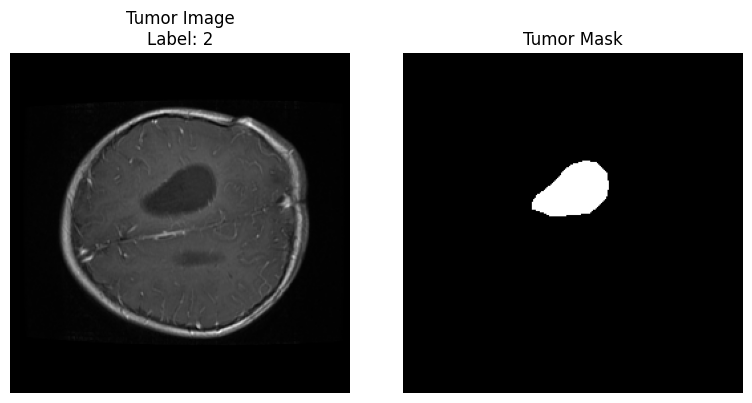

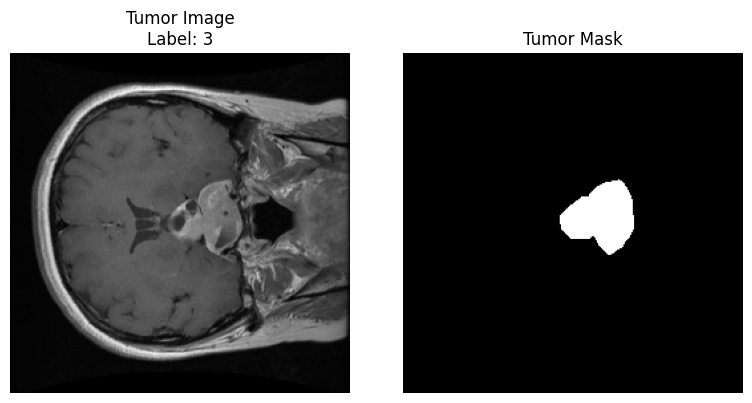

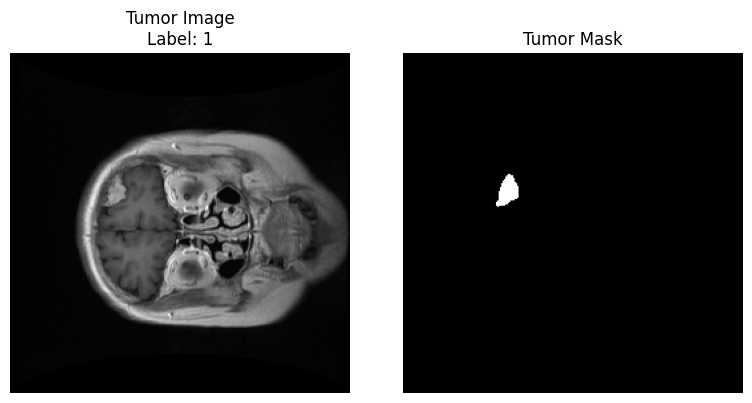

In [3]:
import random
import numpy as np
import h5py
import os
import cv2
import matplotlib.pyplot as plt

# path to dataset
# data_dir = "D:\\BACHELOR THESIS\\dataset\\ashkhagan\\figshare-brain-tumor-dataset\\versions\\1\\dataset\\data" # pt windows
data_dir = "/Users/horiaionescu/.cache/kagglehub/datasets/ashkhagan/figshare-brain-tumor-dataset/versions/1/dataset/data" # pt mac
total_images = 3064

X_tumor = []
Y_tumor_mask = []
tumor_labels = []


for i in range(1, total_images + 1):
    filename = str(i) + ".mat"
    file_path = os.path.join(data_dir, filename)

    # mat file using h5py (for matlab v7.3 files)
    with h5py.File(file_path, "r") as data:
        # tumor image, resize and normalize for model input
        image = np.array(data["cjdata"]["image"])
        image = cv2.resize(image, (256, 256))  # Resize to 256x256 pixels
        image = image / 255.0  # Normalize pixel values to [0, 1]
        X_tumor.append(image)

        # tumor mask, resize and threshold into a binary image
        mask = np.array(data["cjdata"]["tumorMask"])
        mask = cv2.resize(mask, (256, 256))
        mask = (mask > 0).astype(np.uint8)  # Convert to binary mask
        Y_tumor_mask.append(mask)

        # tumor label (1: Meningioma, 2: Glioma, 3: Pituitary Tumor)
        label = int(np.array(data["cjdata"]["label"])[0][0])
        tumor_labels.append(label)

# lists to NumPy arrays
# add extra channel dimension (grayscale) for compatibility with most CNNs
X_tumor = np.array(X_tumor).reshape(-1, 256, 256, 1)
Y_tumor_mask = np.array(Y_tumor_mask).reshape(-1, 256, 256, 1)
tumor_labels = np.array(tumor_labels)


print("Dataset Shapes:")
print("X_tumor:", X_tumor.shape)
print("Y_tumor_mask:", Y_tumor_mask.shape)
print("Tumor Labels:", tumor_labels.shape)
print("Unique Labels:", np.unique(tumor_labels))


# visualize

num_samples = 5

sample_indices = random.sample(range(len(X_tumor)), num_samples)

for idx in sample_indices:
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(X_tumor[idx].squeeze(), cmap='gray')
    plt.title(f"Tumor Image\nLabel: {tumor_labels[idx]}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(Y_tumor_mask[idx].squeeze(), cmap='gray')
    plt.title("Tumor Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# 256x256x1 needed for segmentation
# for classification, we'll need 256x256x3 , 3 channel rgb

# 3. Preprocessing for Segmentation Only (for now)

In [4]:
# resize 256x256x1 already done
# normalization already done
# grayscale as well, here we just do a check to ensure all are greyscale
# and padding to ensure uniformity

target_height = 256
target_width = 256

def check_and_pad(image, target_height, target_width):
    current_height, current_width = image.shape[:2]

    # Return image as is if dimensions match target
    if current_height == target_height and current_width == target_width:
        return image

    # Compute required padding
    pad_height = target_height - current_height
    pad_width = target_width - current_width

    if image.ndim == 3:
        padded_image = np.pad(image, ((0, pad_height), (0, pad_width), (0, 0)),
                              mode='constant', constant_values=0)
    else:
        padded_image = np.pad(image, ((0, pad_height), (0, pad_width)),
                              mode='constant', constant_values=0)
    return padded_image

X_tumor_processed = []

for img in X_tumor:
    # If the image has more than one channel, convert it to grayscale.
    if img.ndim == 3 and img.shape[-1] != 1:
        # Convert image from normalized [0,1] range to [0,255] for cv2 conversion.
        img_8bit = (img * 255).astype(np.uint8)
        img_gray = cv2.cvtColor(img_8bit, cv2.COLOR_BGR2GRAY)
        # Normalize back to [0,1] and expand dims to add channel dimension.
        img_gray = img_gray.astype(np.float32) / 255.0
        img = np.expand_dims(img_gray, axis=-1)

    img_2d = img.squeeze()
    img_padded = check_and_pad(img_2d, target_height, target_width)
    img_final = np.expand_dims(img_padded, axis=-1)
    X_tumor_processed.append(img_final)

X_tumor_processed = np.array(X_tumor_processed)
print("Processed X_tumor shape:", X_tumor_processed.shape)


Processed X_tumor shape: (3064, 256, 256, 1)


# 4. Custom dataset, Lightning DataModule

In [28]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl

# Custom Dataset class
class BrainTumorDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        """
        images: numpy array of shape (N, 256, 256, 1)
        masks: numpy array of shape (N, 256, 256, 1)
        """
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Convert image and mask to torch tensors and squeeze the channel dimension if needed
        image = torch.tensor(self.images[idx], dtype=torch.float32).permute(2, 0, 1)  # from HWC to CHW
        mask = torch.tensor(self.masks[idx], dtype=torch.float32).permute(2, 0, 1)     # from HWC to CHW

        return image, mask

# PyTorch Lightning DataModule
class BrainTumorDataModule(pl.LightningDataModule):
    def __init__(self, images, masks, batch_size=16, val_split=0.2, test_split=0.1, num_workers=0):
        super().__init__()
        self.images = images
        self.masks = masks
        self.batch_size = batch_size
        self.val_split = val_split
        self.test_split = test_split
        self.num_workers = num_workers

    def setup(self, stage=None):
        # Create the full dataset
        full_dataset = BrainTumorDataset(self.images, self.masks)
        dataset_size = len(full_dataset)

        # Determine split sizes
        test_size = int(self.test_split * dataset_size)
        val_size = int(self.val_split * (dataset_size - test_size))
        train_size = dataset_size - test_size - val_size

        # Randomly split the dataset
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            full_dataset, [train_size, val_size, test_size]
        )
        print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,
                          shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)


batch_size = 16
data_module = BrainTumorDataModule(X_tumor_processed, Y_tumor_mask, batch_size=batch_size)
data_module.setup()

train_loader = data_module.train_dataloader()
for batch in train_loader:
    images, masks = batch
    print("Batch images shape:", images.shape)  # Expected: (batch_size, 1, 256, 256)
    print("Batch masks shape:", masks.shape)      # Expected: (batch_size, 1, 256, 256)
    break


Train size: 2207, Val size: 551, Test size: 306
Batch images shape: torch.Size([16, 1, 256, 256])
Batch masks shape: torch.Size([16, 1, 256, 256])


# 5. Model, UNet Lightning

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

# Convolutional block: Conv -> ReLU -> Conv -> ReLU
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x

# Updated UNet model that correctly tracks channels in the decoder
class UNet(pl.LightningModule):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.save_hyperparameters()

        # Encoder: Contracting path
        self.encoder_blocks = nn.ModuleList()
        current_channels = in_channels
        for feature in features:
            self.encoder_blocks.append(ConvBlock(current_channels, feature))
            current_channels = feature
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck: doubles the number of channels of last encoder block
        self.bottleneck = ConvBlock(current_channels, current_channels * 2)
        decoder_channels = current_channels * 2  # Bottleneck output channels

        # Decoder: Expanding path
        self.upconvs = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()
        for feature in reversed(features):
            # Upconv: reduces decoder_channels to current "feature" channels
            self.upconvs.append(nn.ConvTranspose2d(decoder_channels, feature, kernel_size=2, stride=2))
            # After concatenating with skip connection, we have 2*feature channels
            self.decoder_blocks.append(ConvBlock(feature * 2, feature))
            decoder_channels = feature  # update for next iteration

        # Final 1x1 convolution for segmentation mask output
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        # Encoder
        for enc in self.encoder_blocks:
            x = enc(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Reverse the skip connections for decoder
        skip_connections = skip_connections[::-1]

        # Decoder
        for idx in range(len(self.upconvs)):
            x = self.upconvs[idx](x)
            skip_connection = skip_connections[idx]
            # Ensure same spatial dimensions (in case of rounding issues)
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:])
            # Concatenate along channel dimension
            x = torch.cat((skip_connection, x), dim=1)
            x = self.decoder_blocks[idx](x)

        return torch.sigmoid(self.final_conv(x))

    def training_step(self, batch, batch_idx):
        images, masks = batch
        preds = self.forward(images)
        loss = F.binary_cross_entropy(preds, masks)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch
        preds = self.forward(images)
        loss = F.binary_cross_entropy(preds, masks)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    # def test_step(self, batch, batch_idx):
    #     images, masks = batch
    #     preds = self.forward(images)
    #     loss = F.binary_cross_entropy(preds, masks)
    #     self.log('test_loss', loss, prog_bar=True)
    #     return loss


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


# 6. Train

In [32]:
# Example usage (assuming your DataModule is already defined as 'data_module'):
model = UNet(in_channels=1, out_channels=1)
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model, datamodule=data_module)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Train size: 2207, Val size: 551, Test size: 306



  | Name           | Type       | Params | Mode 
------------------------------------------------------
0 | encoder_blocks | ModuleList | 4.7 M  | train
1 | pool           | MaxPool2d  | 0      | train
2 | bottleneck     | ConvBlock  | 14.2 M | train
3 | upconvs        | ModuleList | 2.8 M  | train
4 | decoder_blocks | ModuleList | 9.4 M  | train
5 | final_conv     | Conv2d     | 65     | train
------------------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.122   Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 138/138 [04:10<00:00,  0.55it/s, v_num=3, train_loss_step=0.0645]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 138/138 [04:08<00:00,  0.55it/s, v_num=3, train_loss_step=0.0763, val_loss=0.0723, train_loss_epoch=0.123]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 138/138 [04:13<00:00,  0.54it/s, v_num=3, train_loss_step=0.0659, val_loss=0.0705, train_loss_epoch=0.0742]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 138/138 [04:56<00:00,  0.47it/s, v_num=3, train_loss_step=0.0584, val_loss=0.0787, train_loss_epoch=0.0701]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 138/138 [04:38<00:00,  0.50it/s, v_num=3, train_loss_step=0.0874, val_loss=0.0718, train_loss_epoch=0.0694]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 138/138 [04:13<00:00,  0.54it/s, v_num=3, train_loss_step=0.0602, val_loss=0.0667, train_loss_epoch=0.068] 
Validatio

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 138/138 [04:37<00:00,  0.50it/s, v_num=3, train_loss_step=0.049, val_loss=0.0552, train_loss_epoch=0.0538]


# 7.1 Validation and Test losses

In [43]:
trainer.validate(model, datamodule=data_module)

print("\n")

model.test_step = model.validation_step

trainer.test(model, datamodule=data_module)

Train size: 2207, Val size: 551, Test size: 306
Validation DataLoader 0: 100%|██████████| 35/35 [00:17<00:00,  2.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.05214174464344978
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Train size: 2207, Val size: 551, Test size: 306
Testing DataLoader 0: 100%|██████████| 20/20 [00:09<00:00,  2.07it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss  

[{'val_loss': 0.052788540720939636}]

# 7.2 Dice coef


Evaluating Test Set: 100%|██████████| 20/20 [01:16<00:00,  3.82s/it]

Average Dice Coefficient on Test Set: 0.0336


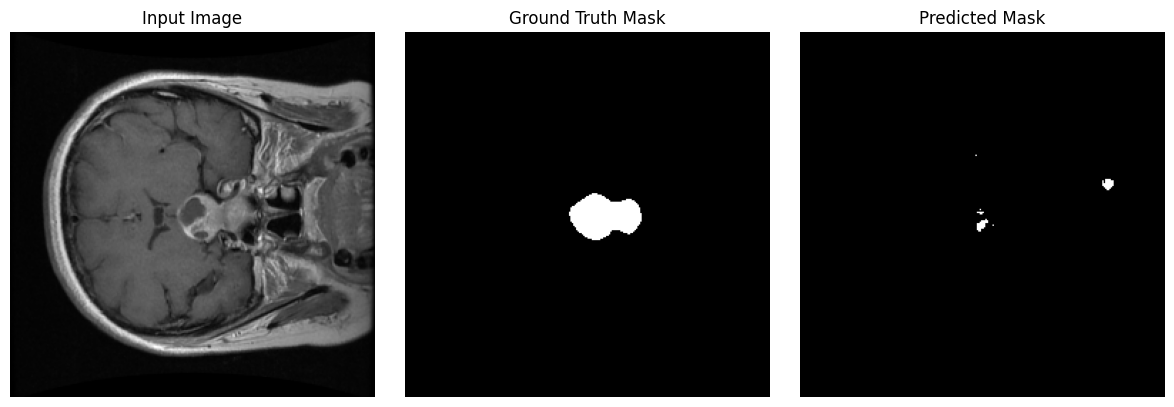

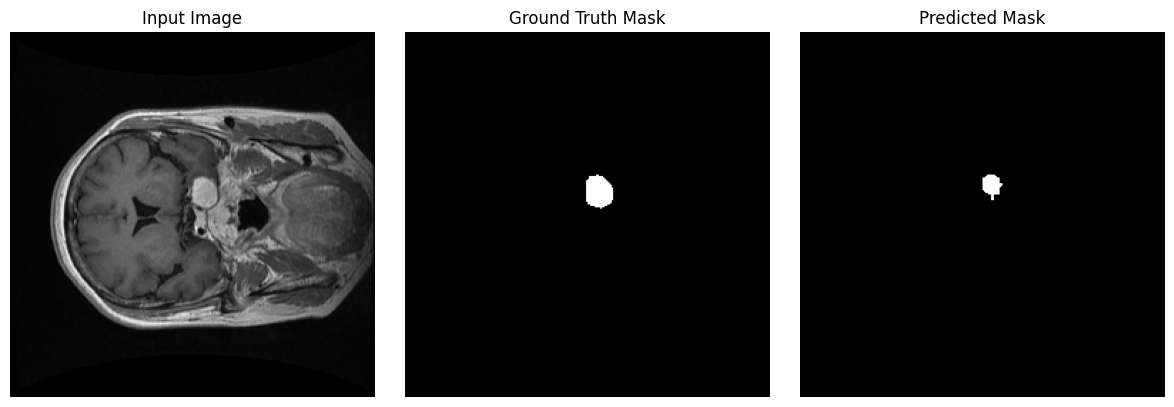

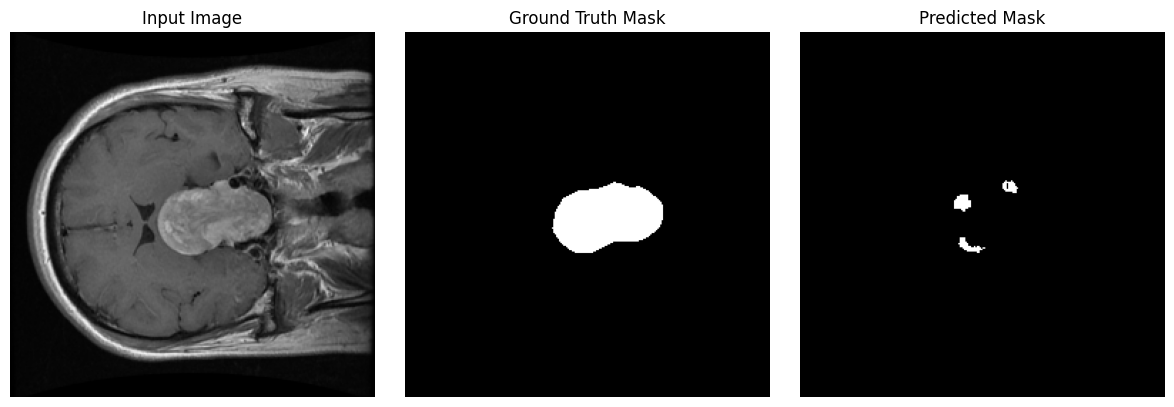

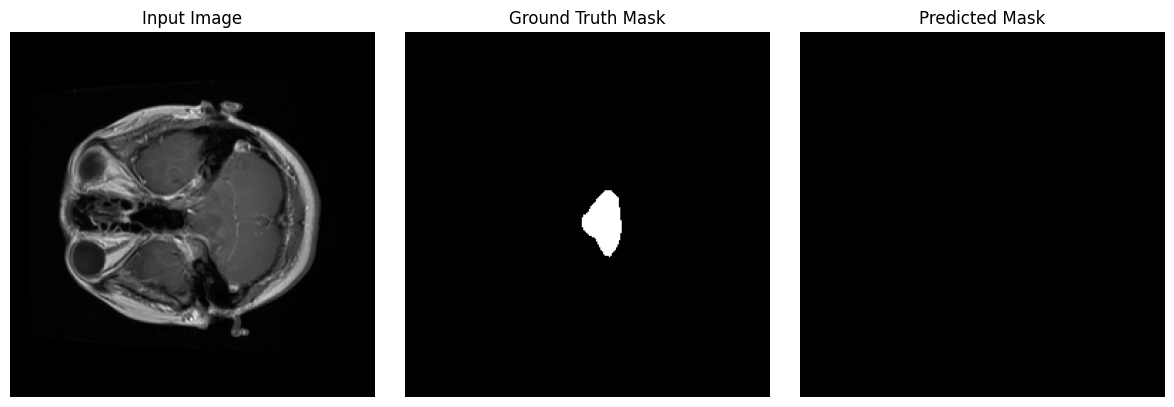

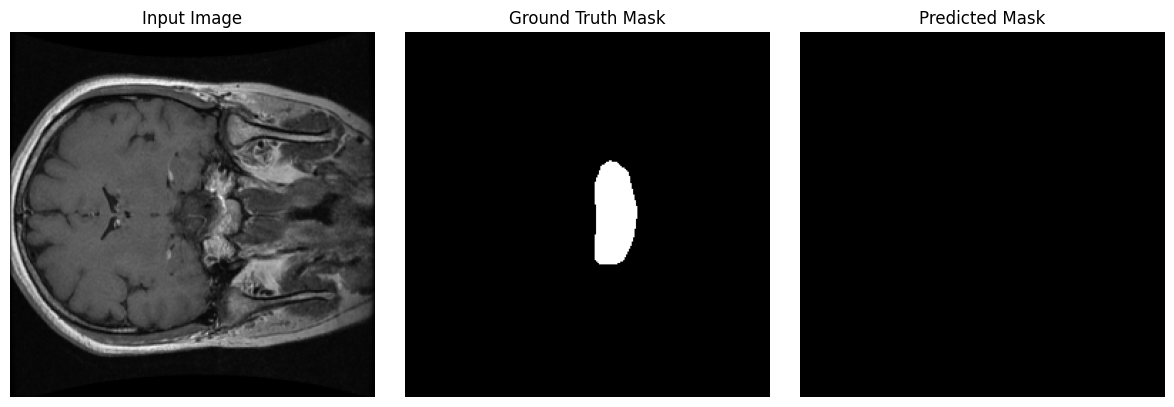

In [47]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Dice coefficient function (as defined earlier)
def dice_coefficient(preds, targets, threshold=0.5, epsilon=1e-6):
    preds_bin = (preds > threshold).float()
    intersection = (preds_bin * targets).sum(dim=(1,2,3))
    total = preds_bin.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
    dice = (2.0 * intersection + epsilon) / (total + epsilon)
    return dice.mean()

# Evaluate the model on the test set and compute the average Dice coefficient.
model.eval()
test_loader = data_module.test_dataloader()
# train_loader = data_module.train_dataloader()
dice_total = 0.0
n_samples = 0

# Lists to accumulate predictions and corresponding images and masks for visualization.
all_images = []
all_masks = []
all_preds = []

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Evaluating Test Set"):
        preds = model(images)
        # Compute Dice for the batch.
        batch_dice = dice_coefficient(preds, masks)
        dice_total += batch_dice.item() * images.size(0)
        n_samples += images.size(0)

        # Save outputs for visualization.
        all_images.append(images)
        all_masks.append(masks)
        all_preds.append(preds)

avg_dice = dice_total / n_samples
print(f"Average Dice Coefficient on Test Set: {avg_dice:.4f}")

# Concatenate all batches for visualization.
images = torch.cat(all_images, dim=0)
masks = torch.cat(all_masks, dim=0)
preds = torch.cat(all_preds, dim=0)

# Select a few random samples from the test set.
num_samples = 5
indices = torch.randperm(images.shape[0])[:num_samples]

for idx in indices:
    # Convert tensors to numpy arrays.
    image = images[idx].cpu().numpy().squeeze()  # shape (H, W)
    mask = masks[idx].cpu().numpy().squeeze()      # shape (H, W)
    pred = preds[idx].cpu().numpy().squeeze()      # shape (H, W)

    # For visualization, threshold the prediction.
    pred_bin = (pred > 0.5).astype(float)

    # Plot the input image, ground truth mask, and predicted mask.
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_bin, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
